In [1]:
import numpy as np
import scipy
import algorithmsPart2 as alg
import FrameGraphPart2 as fg
import pickle



PARAMS = {
    'match_threshold': 0.9,
    'edges_num_neighbors': 3,
    'edges_inliers_threshold': 20, # 12 also works well
    'node_reference_index': 0,
    'RANSAC_inlier_threshold': 2.0,
    'RANSAC_max_iter': 700,
    
    'MSAC_max_iter': 1500,
    'MSAC_threshold': 1.9,
    'MSAC_confidence': 0.999,
}


cams_info_data = scipy.io.loadmat('office/cams_info_no_extr.mat')
kp_data = scipy.io.loadmat('office/kp.mat')
wrld_data = scipy.io.loadmat('office/wrld_info.mat')



### Convert the data to the appropriate format
num_images = 10

rgb_shape = cams_info_data['cams_info'][0][0]['rgb'][0][0].shape
rgb_type = cams_info_data['cams_info'][0][0]['rgb'][0][0].dtype

depth_shape = cams_info_data['cams_info'][0][0]['depth'][0][0].shape
depth_type = cams_info_data['cams_info'][0][0]['depth'][0][0].dtype

conf_shape = cams_info_data['cams_info'][0][0]['conf'][0][0].shape
conf_type = cams_info_data['cams_info'][0][0]['conf'][0][0].dtype


rgb_images = np.zeros((rgb_shape[0], rgb_shape[1], rgb_shape[2], num_images), dtype=rgb_type)
depth_images = np.zeros((depth_shape[0], depth_shape[1], num_images), dtype=depth_type)
conf_images = np.zeros((conf_shape[0], conf_shape[1], num_images), dtype=conf_type)

fx_vec = np.zeros((num_images), dtype=np.float64)
fy_vec = np.zeros((num_images), dtype=np.float64)

for i in range(num_images):
    rgb_images[..., i] = cams_info_data['cams_info'][i][0]['rgb'][0][0]
    depth_images[..., i] = cams_info_data['cams_info'][i][0]['depth'][0][0]
    conf_images[..., i] = cams_info_data['cams_info'][i][0]['conf'][0][0]
    
    fx_vec[i] = cams_info_data['cams_info'][i][0]['focal_lenght'][0,0][0,0]
    fy_vec[i] = cams_info_data['cams_info'][i][0]['focal_lenght'][0,0][0,0]


cx = rgb_shape[1] / 2
cy = rgb_shape[0] / 2


### Preprocess depth
def preprocess_depth(depth, conf, threshold=0.5):
    
    mask = conf > threshold
    depth_filtered = np.where(mask, depth, 0)
    return depth_filtered


depth_images_filtered = np.zeros_like(depth_images)
intrinsecs = []

for i in range(num_images):
    depth_images_filtered[..., i] = preprocess_depth(depth_images[..., i], conf_images[..., i])
    intrinsecs.append((fx_vec[i], fy_vec[i], cx, cy))


###! create the Graph to extract the keypoint descriptor and features
nodes = fg.initialize_graph(kp_data, depth_images_filtered, rgb_images, intrinsecs)


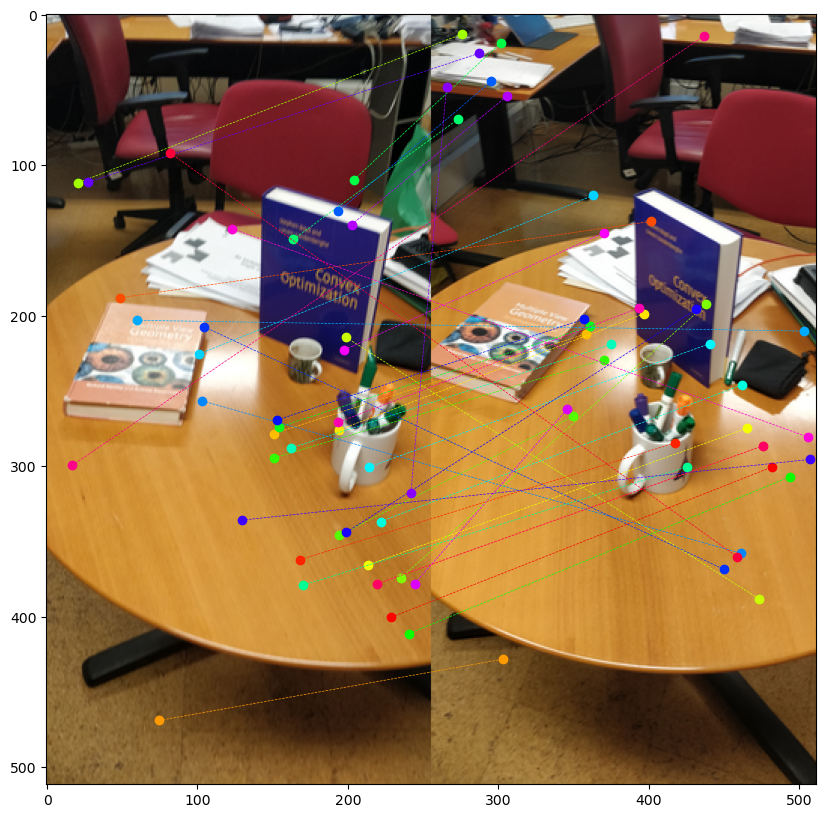

In [15]:
i = 0
j = 3

matches = alg.hybrid_matching(nodes[i].desc, nodes[j].desc, ratio=0.8)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
### plot the matches in the two images

import matplotlib.pyplot as plt

img1 = rgb_images[..., i]
img2 = rgb_images[..., j]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.concatenate((img1, img2), axis=1))

# Generate unique colors using a colormap
cmap = plt.get_cmap('hsv')
colors = [cmap(i / len(matches)) for i in range(len(matches))]

for idx, m in enumerate(matches):
    x1, y1 = nodes[i].kp[m[0]]
    x2, y2 = nodes[j].kp[m[1]]
    x2 += img1.shape[1]
    
    color = colors[idx]
    ax.plot(x1, y1, 'o', color=color)
    ax.plot(x2, y2, 'o', color=color)
    ax.plot([x1, x2], [y1, y2], linestyle='--', color=color, linewidth=0.5)

plt.show()